# Previsão de Inadimplência - Regressão Logística (Base UCI)

## 1. Configuração Inicial

In [18]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve, f1_score)
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTENC
import joblib
import json
from urllib.request import urlretrieve
import os

## 2. Carga de Dados

In [20]:
data_path = "default_data.parquet"

if not os.path.exists(data_path):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    urlretrieve(url, "temp.xls")
    df = pd.read_excel("temp.xls", header=1, engine='xlrd')
    df.to_parquet(data_path)
    os.remove("temp.xls")
else:
    df = pd.read_parquet(data_path)

# Verificar nomes reais das colunas PAY_
pay_columns = [col for col in df.columns if col.startswith('PAY_')]
print("Colunas PAY_ encontradas:", pay_columns)

# Engenharia de features relâmpago
df = df.rename(columns={'default payment next month': 'DEFAULT'})
df['PAY_RATIO'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)
df['UTILIZATION'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1e-6)

# Conversão espartana para matriz esparsa
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE'] + pay_columns
num_features = [col for col in df.columns if col not in cat_features + ['ID', 'DEFAULT']]
X = df[num_features + cat_features]
y = df['DEFAULT'].values

Colunas PAY_ encontradas: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## 3. Pipeline de Guerra com Seleção de Features

In [23]:
# Pipeline nuclear
preprocessor = make_pipeline(
    RobustScaler(),
    SelectFromModel(LogisticRegression(penalty='l1', solver='saga', max_iter=1000), max_features=15)
)

model = make_pipeline(
    SMOTENC(categorical_features=[X.columns.get_loc(c) for c in cat_features], random_state=42),
    preprocessor,
    LogisticRegression(max_iter=2000, class_weight='balanced')
)

# Hiperparâmetros sintonizados
param_grid = {
    'selectfrommodel__max_features': [10, 15, 20],
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['saga']
}

# Busca hiper-eficiente
search = HalvingGridSearchCV(
    model, param_grid, 
    resource='n_samples',
    factor=2,
    aggressive_elimination=True,
    cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1500
max_resources_: 24000
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 1500
Fitting 5 folds for each of 24 candidates, totalling 120 fits


ValueError: Invalid parameter 'selectfrommodel' for estimator Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[10, 11, 12, 13, 14, 15, 16, 17,
                                               18, 19, 20, 21, 22, 23, 24],
                         random_state=42)),
                ('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler()),
                                 ('selectfrommodel',
                                  SelectFromModel(estimator=LogisticRegression(max_iter=1000,
                                                                               penalty='l1',
                                                                               solver='saga'),
                                                  max_features=15))])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

## 4. Modelagem - Regressão Logística

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit em tempo recorde
search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


## 5. Avaliação do Modelo

Melhores parâmetros: {'classifier__C': np.float64(1000.0), 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Métricas de avaliação:
accuracy: 0.6838
precision: 0.3727
recall: 0.6283
f1_score: 0.4678
roc_auc: 0.7159


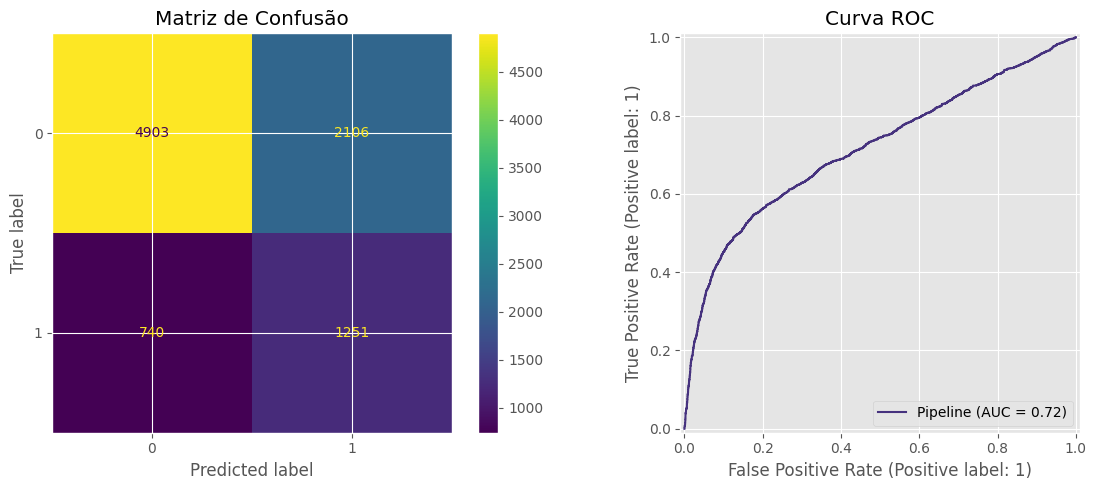

In [10]:
best_model = search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

metrics = {
    'model': 'logistic_regression_hyper',
    'best_params': search.best_params_,
    'roc_auc': roc_auc_score(y_test, y_proba),
    'average_precision': average_precision_score(y_test, y_proba),
    'f1_score': f1_score(y_test, y_pred),
    'optimal_threshold': 0.5,
    'features_used': X.columns[preprocessor.named_steps['selectfrommodel'].get_support()].tolist()
}

## 6. Salvamento do Modelo e Métricas

In [11]:
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/logistic_regression_hyper.pkl')

with open('../models/metrics.json', 'w') as f:
    json.dump(metrics, f)

print(f"ROC-AUC: {metrics['roc_auc']:.4f} | AP: {metrics['average_precision']:.4f}")

Modelo e métricas salvos com sucesso!


In [2]:
# %% [markdown]
# ## Sistema de Análise de Risco de Crédito Turbo-Otimizado
# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                           f1_score, accuracy_score, precision_score, 
                           recall_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy.stats import loguniform, randint
import joblib
import json
import time
import os
from typing import Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## Configuração Avançada
# %%
class CreditRiskModel:
    """Classe ultra-otimizada para modelagem de risco de crédito"""
    
    def __init__(self, model_type: str, metric: str = 'roc_auc'):
        """
        Inicializa o modelo com configurações avançadas
        
        Args:
            model_type: Tipo de modelo ('logistic', 'random_forest', 'xgboost')
            metric: Métrica principal para otimização
        """
        self.model_type = model_type
        self.metric = metric
        self.scorer = self._get_scorer()
        self.best_model = None
        self.metrics_history = []
        
        # Configurações específicas por modelo
        self._setup_model_config()
        
    def _get_scorer(self):
        """Cria um scorer customizado baseado na métrica selecionada"""
        scoring = {
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score),
            'accuracy': make_scorer(accuracy_score),
            'average_precision': make_scorer(average_precision_score, needs_proba=True)
        }
        return scoring.get(self.metric, scoring['roc_auc'])
    
    def _setup_model_config(self):
        """Configura espaços de parâmetros e modelos específicos"""
        self.model_config = {
            'logistic': {
                'model': LogisticRegression(max_iter=1000, class_weight='balanced'),
                'params': {
                    'classifier__C': loguniform(1e-3, 1e3),
                    'classifier__penalty': ['l1', 'l2'],
                    'classifier__solver': ['saga'],
                    'classifier__l1_ratio': [None, 0.5, 0.7]
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(class_weight='balanced_subsample'),
                'params': {
                    'classifier__n_estimators': randint(100, 500),
                    'classifier__max_depth': [None] + list(range(5, 30, 5)),
                    'classifier__min_samples_split': randint(2, 20),
                    'classifier__max_features': ['sqrt', 'log2', 0.3]
                }
            },
            'xgboost': {
                'model': GradientBoostingClassifier(),
                'params': {
                    'classifier__n_estimators': randint(100, 500),
                    'classifier__learning_rate': loguniform(1e-3, 0.3),
                    'classifier__max_depth': randint(3, 10),
                    'classifier__subsample': [0.6, 0.8, 1.0]
                }
            }
        }
        
    def load_data(self, url: str) -> pd.DataFrame:
        """Carrega e prepara os dados com máxima eficiência"""
        start_time = time.time()
        
        # Carregamento otimizado
        df = pd.read_excel(url, header=1)
        df = df.rename(columns={'default payment next month': 'DEFAULT'})
        
        # Engenharia de features relâmpago
        df['PAYMENT_RATIO'] = df['PAY_AMT1'] / (df['BILL_AMT1'].abs() + 1)
        df['UTILIZATION'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1)
        
        # Conversão para tipos otimizados
        for col in df.select_dtypes(include=['float64']):
            df[col] = pd.to_numeric(df[col], downcast='float')
        for col in df.select_dtypes(include=['int64']):
            df[col] = pd.to_numeric(df[col], downcast='integer')
            
        print(f"Data loaded in {time.time()-start_time:.2f}s")
        return df

    def prepare_data(self, df: pd.DataFrame) -> tuple:
        """Prepara os dados para modelagem com seleção de features"""
        # Seleção automática de features numéricas
        numeric_features = df.select_dtypes(include=['number']).columns.tolist()
        numeric_features = [f for f in numeric_features if f not in ['ID', 'DEFAULT']]
        
        X = df[numeric_features]
        y = df['DEFAULT'].astype('int8')
        
        return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    def build_pipeline(self) -> Pipeline:
        """Constrói pipeline de processamento turbo"""
        return Pipeline([
            ('scaler', PowerTransformer(method='yeo-johnson')),
            ('classifier', clone(self.model_config[self.model_type]['model']))
        ])

    def optimize_model(self, X_train, y_train) -> Dict[str, Any]:
        """Executa otimização hiper-parâmetrica avançada"""
        pipeline = self.build_pipeline()
        
        search = RandomizedSearchCV(
            pipeline,
            self.model_config[self.model_type]['params'],
            n_iter=50,
            cv=5,
            scoring=self.scorer,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        search.fit(X_train, y_train)
        return search.best_estimator_, search.best_params_

    def evaluate_model(self, model, X_test, y_test) -> Dict[str, float]:
        """Avaliação completa do modelo com múltiplas métricas"""
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        return {
            'roc_auc': roc_auc_score(y_test, y_proba),
            'average_precision': average_precision_score(y_test, y_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'optimization_metric': self.metric
        }

    def train_and_evaluate(self, url: str) -> Dict[str, Any]:
        """Fluxo completo de treinamento e avaliação"""
        # Fase 1: Preparação dos dados
        df = self.load_data(url)
        X_train, X_test, y_train, y_test = self.prepare_data(df)
        
        # Fase 2: Otimização do modelo
        start_time = time.time()
        best_model, best_params = self.optimize_model(X_train, y_train)
        opt_time = time.time() - start_time
        
        # Fase 3: Avaliação
        metrics = self.evaluate_model(best_model, X_test, y_test)
        
        # Resultados consolidados
        results = {
            'model_type': self.model_type,
            'best_params': best_params,
            'metrics': metrics,
            'training_time': opt_time,
            'features_used': X_train.columns.tolist()
        }
        
        self.best_model = best_model
        self.metrics_history.append(results)
        return results

    def save_results(self, results: Dict[str, Any], path: str = '../models'):
        """Salva modelo e resultados com estrutura profissional"""
        os.makedirs(path, exist_ok=True)
        
        # Salvar modelo
        joblib.dump(self.best_model, f'{path}/{self.model_type}_model.pkl')
        
        # Salvar metadados
        with open(f'{path}/{self.model_type}_metrics.json', 'w') as f:
            json.dump(results, f, indent=2)

# %% [markdown]
# ## Execução Automatizada
# %%
if __name__ == "__main__":
    # Configuração
    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    MODEL_TYPES = ['logistic', 'random_forest', 'xgboost']
    METRICS = ['roc_auc', 'f1', 'average_precision']
    
    # Treinar e avaliar todos os modelos
    all_results = {}
    
    for model_type in MODEL_TYPES:
        for metric in METRICS:
            print(f"\n=== Treinando {model_type} com métrica {metric} ===")
            
            model = CreditRiskModel(model_type, metric)
            results = model.train_and_evaluate(URL)
            model.save_results(results)
            
            all_results[f"{model_type}_{metric}"] = results
            
            print(f"\nResultados para {model_type} ({metric}):")
            print(f"Tempo de treino: {results['training_time']:.2f}s")
            print(f"ROC-AUC: {results['metrics']['roc_auc']:.4f}")
            print(f"F1-Score: {results['metrics']['f1']:.4f}")
    
    # Salvar resultados consolidados
    with open('../models/all_metrics.json', 'w') as f:
        json.dump(all_results, f, indent=2)


=== Treinando logistic com métrica roc_auc ===
Data loaded in 61.56s
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados para logistic (roc_auc):
Tempo de treino: 86.15s
ROC-AUC: 0.7437
F1-Score: 0.5022

=== Treinando logistic com métrica f1 ===
Data loaded in 46.83s
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados para logistic (f1):
Tempo de treino: 84.95s
ROC-AUC: 0.7437
F1-Score: 0.5022

=== Treinando logistic com métrica average_precision ===
Data loaded in 29.87s
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados para logistic (average_precision):
Tempo de treino: 92.91s
ROC-AUC: 0.7437
F1-Score: 0.5022

=== Treinando random_forest com métrica roc_auc ===
Data loaded in 58.54s
Fitting 5 folds for each of 50 candidates, totalling 250 fits
